# 2) Targeted FGSM (Linf)

## 2.1) Preparation

In [1]:
from utils import *
import torch
from models.blip import blip_decoder
from torchmetrics.functional.image import peak_signal_noise_ratio

In [2]:
# set hyperparameters
IMG_SIZE = 384
MODEL_PATH = "./pretrained_wights/model_base_caption_capfilt_large.pth"
IMG_PATH = "./imgs/demo.jpg"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Selected device: {DEVICE.type}")

Selected device: cuda


In [3]:
# prepare the img
img = preprocess_img(IMG_PATH, IMG_SIZE)
img = normalize(img)
img = img.to(DEVICE)

In [4]:
# load BLIP image-to-caption model
model = blip_decoder(pretrained=MODEL_PATH, image_size=IMG_SIZE, vit='base')
model.eval()
model = model.to(DEVICE)

load checkpoint from ./pretrained_wights/model_base_caption_capfilt_large.pth


## 2.2) Changing a Single Word in the Caption

In [5]:
orig_caption   = "a woman sitting on the beach with a dog"
target_caption = "a man sitting on the beach with a dog"

with torch.no_grad():
    orig_loss = model(img, model.prompt + orig_caption)
    target_loss = model(img, model.prompt + target_caption)
    print(f"Orig caption  : {orig_caption}, loss: {orig_loss.item():.3f}")
    print(f"Target caption: {target_caption}, loss: {target_loss.item():.3f}")

Orig caption  : a woman sitting on the beach with a dog, loss: 1.853
Target caption: a man sitting on the beach with a dog, loss: 2.446


![formula](./assets/formulas/2.png)

In [6]:
epsilon=0.02  # maximum L-infinity norm of the adversarial perturbation

img.requires_grad = True
loss = model(img, model.prompt + target_caption)

if img.grad is not None:
    img.grad.zero_()
loss.backward()

adv_img = img - epsilon * img.grad.sign()  # move towards the opposite direction of the gradient's sign (steepest descent) 

# detach tensors from the computation graph
adv_img = adv_img.detach()
img = img.detach()

In [7]:
with torch.no_grad():
    orig_loss = model(adv_img, model.prompt + orig_caption)
    target_loss = model(adv_img, model.prompt + target_caption)
    print(f"Orig caption  : {orig_caption}, loss: {orig_loss.item():.3f}")
    print(f"Target caption: {target_caption}, loss: {target_loss.item():.3f}")

Orig caption  : a woman sitting on the beach with a dog, loss: 1.977
Target caption: a man sitting on the beach with a dog, loss: 1.921


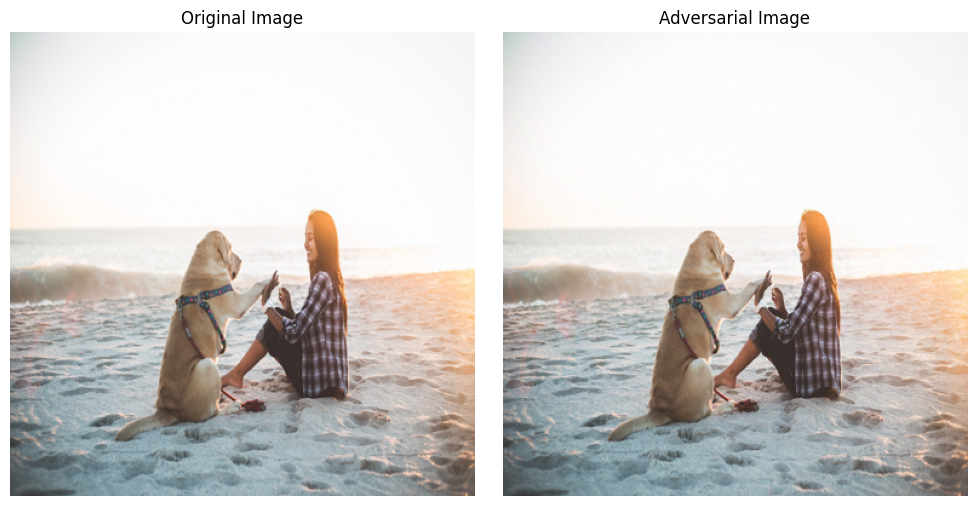

In [8]:
display_img(orig_img_tensor=denormalize(img), adv_img_tensor=denormalize(adv_img))

In [9]:
with torch.no_grad():
    caption = model.generate(adv_img, sample=False, num_beams=3, max_length=20, min_length=5)[0]
    print("Caption generated from adversarial image:")
    print("  " + caption)

Caption generated from adversarial image:
  a man sitting on the beach with a dog


In [10]:
psnr_value = peak_signal_noise_ratio(denormalize(adv_img), denormalize(img)).item()
print(f"PSNR: {psnr_value:.2f} dB")

PSNR: 44.07 dB
